# Data Ingestion

In [1]:
import torch
import numpy as np
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [2]:
import scipy.io as sio

kuka_data = sio.loadmat('/kaggle/input/industrial-manipulator-forward-dynamics-data/KukaDirectDynamics.mat')

In [3]:
print(kuka_data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'kukatraj1', 'kukatraj10', 'kukatraj2', 'kukatraj3', 'kukatraj4', 'kukatraj5', 'kukatraj6', 'kukatraj7', 'kukatraj8', 'kukatraj9'])


# Preprocessing

In [4]:
import numpy as np

trajectories = {}
total = 0
# Filter out non-trajectory keys and prepare data for training
for key, value in kuka_data.items():
    if key.startswith('kukatraj') and isinstance(value, np.ndarray):
      print(f'{key} - {len(value)}')
      total += len(value)
      trajectories[key] = value

print(f'Total: {total}')

kukatraj1 - 1814
kukatraj10 - 1997
kukatraj2 - 1857
kukatraj3 - 1971
kukatraj4 - 1941
kukatraj5 - 1915
kukatraj6 - 2061
kukatraj7 - 1984
kukatraj8 - 2509
kukatraj9 - 2019
Total: 20068


In [ ]:
best_params_lstm = {'n_layers': 1,
                    'hidden_size': 416,
                    'learning_rate': 7.712482023726117e-05,
                    'dropout': 0,
                    'sequence_length': 80,
                    'epochs': 125}

# In-depth Evaluation
---

In [ ]:
import torch
import time
import sys
import utils
sys.path.append('models')

import lstm_model

trajectory_keys = sorted(list(trajectories.keys()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("--- LSTM Evaluation Setup ---")
print(f"Using device: {device}")
if torch.cuda.is_available(): print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Trajectories: {len(trajectory_keys)}")
print("-" * 33)


seq_len = best_params_lstm['sequence_length']

--- LSTM Evaluation Setup ---
Using device: cuda
GPU: Tesla P100-PCIE-16GB
Trajectories: 10
---------------------------------


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

overall_start_time = time.time()
trajectory_keys = sorted(list(trajectories.keys()))
fold_results_lstm = []
last_fold_preds = {}
horizons = list(range(100, 1001, 100))
seq_len = best_params_lstm['sequence_length']

for i, test_key in enumerate(trajectory_keys[:4]): # Using all trajectories for full cross-validation
    fold_start_time = time.time()
    print(f"\n--- Fold {i+1}/{len(trajectory_keys)} ---")
    print(f"Testing on: {test_key}")

    # --- Data Preparation ---
    train_keys = [k for k in trajectory_keys if k != test_key]
    train_traj = np.concatenate([trajectories[key] for key in train_keys], axis=0)
    test_traj = trajectories[test_key]

    X_train_np, y_train_np = train_traj[:, :21], train_traj[:, 21:]
    X_test_np, y_test_np = test_traj[:, :21], test_traj[:, 21:]

    # --- Scaling (within the fold) ---
    x_scaler_eval = StandardScaler()
    y_scaler_eval = StandardScaler()
    X_train_scaled = x_scaler_eval.fit_transform(X_train_np)
    y_train_scaled = y_scaler_eval.fit_transform(y_train_np)
    X_test_scaled = x_scaler_eval.transform(X_test_np)
    y_test_scaled = y_scaler_eval.transform(y_test_np) # Scale y_test for step-by-step input

    # Create sequences for training from scaled data
    X_train_seq, y_train_seq = lstm_model.create_sequences(X_train_scaled, y_train_scaled, seq_len)
    X_train_t = torch.from_numpy(X_train_seq).float().to(device)
    y_train_t = torch.from_numpy(y_train_seq).float().to(device)
    X_test_t = torch.from_numpy(X_test_scaled).float().to(device)

    # --- DataLoader ---
    train_dataset = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

    # --- Model Training ---
    model = lstm_model.LSTMModel(
        input_size=21,
        output_size=14,
        hidden_size=best_params_lstm['hidden_size'],
        num_layers=best_params_lstm['n_layers'],
        dropout_rate=best_params_lstm['dropout']
    ).to(device)

    train_time_start = time.time()
    model = lstm_model.train_lstm_model(model, train_loader, best_params_lstm['learning_rate'], best_params_lstm['epochs'])
    training_time = time.time() - train_time_start

    # --- Evaluation ---
    # Scenario A: Step-by-step prediction (predicts scaled, needs scaled y_test)
    y_pred_step_scaled = lstm_model.predict_step_by_step_lstm(model, X_test_scaled, y_test_scaled, seq_len)
    y_pred_step = y_scaler_eval.inverse_transform(y_pred_step_scaled)

    # Scenario B: Full trajectory prediction (predicts scaled)
    y_pred_full_scaled = lstm_model.predict_full_trajectory_lstm(model, X_test_t, seq_len)
    y_pred_full = y_scaler_eval.inverse_transform(y_pred_full_scaled)

    # Align predictions for metric calculation
    y_test_aligned = y_test_np[seq_len:]
    y_pred_step_aligned = y_pred_step[seq_len:]
    y_pred_full_aligned = y_pred_full[seq_len:]

    # --- Calculate Metrics (on original scale) ---
    nmse_step = utils.nMSE(y_test_aligned, y_pred_step_aligned)
    nmse_full = utils.nMSE(y_test_aligned, y_pred_full_aligned)
    euclid_err_step = np.mean(utils.euclidean_error(y_test_aligned, y_pred_step_aligned))
    euclid_err_op_space_full = utils.calculate_op_space_error(y_test_aligned, y_pred_full_aligned)
    print(f"Step-by-Step Pos nMSE       | {np.mean(nmse_step[:7]):.4f}")
    print(f"Full Traj Pos nMSE          | {np.mean(nmse_full[:7]):.4f}")

    current_fold_results = {
        'fold': i + 1, 'training_time': training_time,
        'sbs_pos_nmse': np.mean(nmse_step[:7]),
        'sbs_vel_nmse': np.mean(nmse_step[7:]),
        'sbs_euclid_err': euclid_err_step,
        'full_pos_nmse': np.mean(nmse_full[:7]),
        'full_vel_nmse': np.mean(nmse_full[7:]),
        'full_op_space_error': euclid_err_op_space_full
    }

    # Horizon Analysis
    horizons = list(range(100, 1001, 100))

    for h in horizons:
        y_test_h = y_test_aligned[:h, :]
        y_pred_full_h = y_pred_full_aligned[:h, :]
        nmse_h = utils.nMSE(y_test_h, y_pred_full_h)
        euclid_h = utils.calculate_op_space_error(y_test_h, y_pred_full_h)
        current_fold_results[f'full_pos_nmse_h{h}'] = np.mean(nmse_h[:7])
        current_fold_results[f'full_euclid_err_h{h}'] = euclid_h

    fold_results_lstm.append(current_fold_results)

last_fold_preds = {'true': y_test_np, 'step': y_pred_step, 'full': y_pred_full}


--- Fold 1/10 ---
Testing on: kukatraj1


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


Step-by-Step Pos nMSE       | 0.1013
Full Traj Pos nMSE          | 6.9048

--- Fold 2/10 ---
Testing on: kukatraj10


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


Step-by-Step Pos nMSE       | 0.0043
Full Traj Pos nMSE          | 0.1007

--- Fold 3/10 ---
Testing on: kukatraj2


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


Step-by-Step Pos nMSE       | 0.0122
Full Traj Pos nMSE          | 7.2067

--- Fold 4/10 ---
Testing on: kukatraj3


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.30000000000000004 and num_layers=1
  warnings.warn(


Step-by-Step Pos nMSE       | 0.0064
Full Traj Pos nMSE          | 0.1407


In [20]:
import pandas as pd

# Aggregate and Display Final Results
print("\n\n--- Cross-Validation Complete ---")
print(f"Total execution time: {(time.time() - overall_start_time) / 60:.2f} minutes")

results_df = pd.DataFrame(fold_results_lstm)
mean_results = results_df.mean()
std_results = results_df.std()

print("\n--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---")
print("Metric                      | Mean Value ± Std Deviation")
print("-" * 55)
print(f"Training Time (s)           | {mean_results['training_time']:.2f} ± {std_results['training_time']:.2f}")
print(f"Step-by-Step Pos nMSE       | {mean_results['sbs_pos_nmse']:.4f} ± {std_results['sbs_pos_nmse']:.4f}")
print(f"Step-by-Step Vel nMSE       | {mean_results['sbs_vel_nmse']:.4f} ± {std_results['sbs_vel_nmse']:.4f}")
print(f"Step-by-Step Euclid Err (m) | {mean_results['sbs_euclid_err']:.4f} ± {std_results['sbs_euclid_err']:.4f}")
print(f"Full Traj Pos nMSE          | {mean_results['full_pos_nmse']:.4f} ± {std_results['full_pos_nmse']:.4f}")
print(f"Full Traj Vel nMSE          | {mean_results['full_vel_nmse']:.4f} ± {std_results['full_vel_nmse']:.4f}")
print(f"Full Traj Euclid Err (m) | {mean_results['full_op_space_error']:.4f} ± {std_results['full_op_space_error']:.4f}")

print("-" * 55)

print("\n--- Error Accumulation Over Prediction Horizon ---")
print("Horizon | Position nMSE       | Op. Space Euclid Err (m)")
print("--------|---------------------|--------------------------")
calculated_horizons = sorted([int(c.split('h')[-1]) for c in results_df.columns if 'pos_nmse_h' in c])
for h in calculated_horizons:
    h_col_pos = f'full_pos_nmse_h{h}'
    h_col_euc = f'full_euclid_err_h{h}'
    if h_col_pos in mean_results and h_col_euc in std_results:
        print(f"{h:<8}| {mean_results[h_col_pos]:.4f} ± {std_results[h_col_pos]:.4f}      | {mean_results[h_col_euc]:.4f} ± {std_results[h_col_euc]:.4f}")
print("-" * 55)



--- Cross-Validation Complete ---
Total execution time: 20.36 minutes

--- PC-ESN++ Final Averaged Results (Mean ± Std Dev) ---
Metric                      | Mean Value ± Std Deviation
-------------------------------------------------------
Training Time (s)           | 299.62 ± 2.29
Step-by-Step Pos nMSE       | 0.0311 ± 0.0469
Step-by-Step Vel nMSE       | 0.1456 ± 0.0615
Step-by-Step Euclid Err (m) | 0.0280 ± 0.0282
Full Traj Pos nMSE          | 3.5882 ± 4.0059
Full Traj Vel nMSE          | 1.0068 ± 1.0064
Full Traj Euclid Err (m) | 0.1175 ± 0.0871
-------------------------------------------------------

--- Error Accumulation Over Prediction Horizon ---
Horizon | Position nMSE       | Op. Space Euclid Err (m)
--------|---------------------|--------------------------
100     | 225133434.9982 ± 213571587.2464      | 0.0018 ± 0.0010
200     | 188875.1694 ± 377748.8250      | 0.0079 ± 0.0068
300     | 19.3796 ± 36.8664      | 0.0232 ± 0.0136
400     | 21.7338 ± 41.1880      | 0.0415 

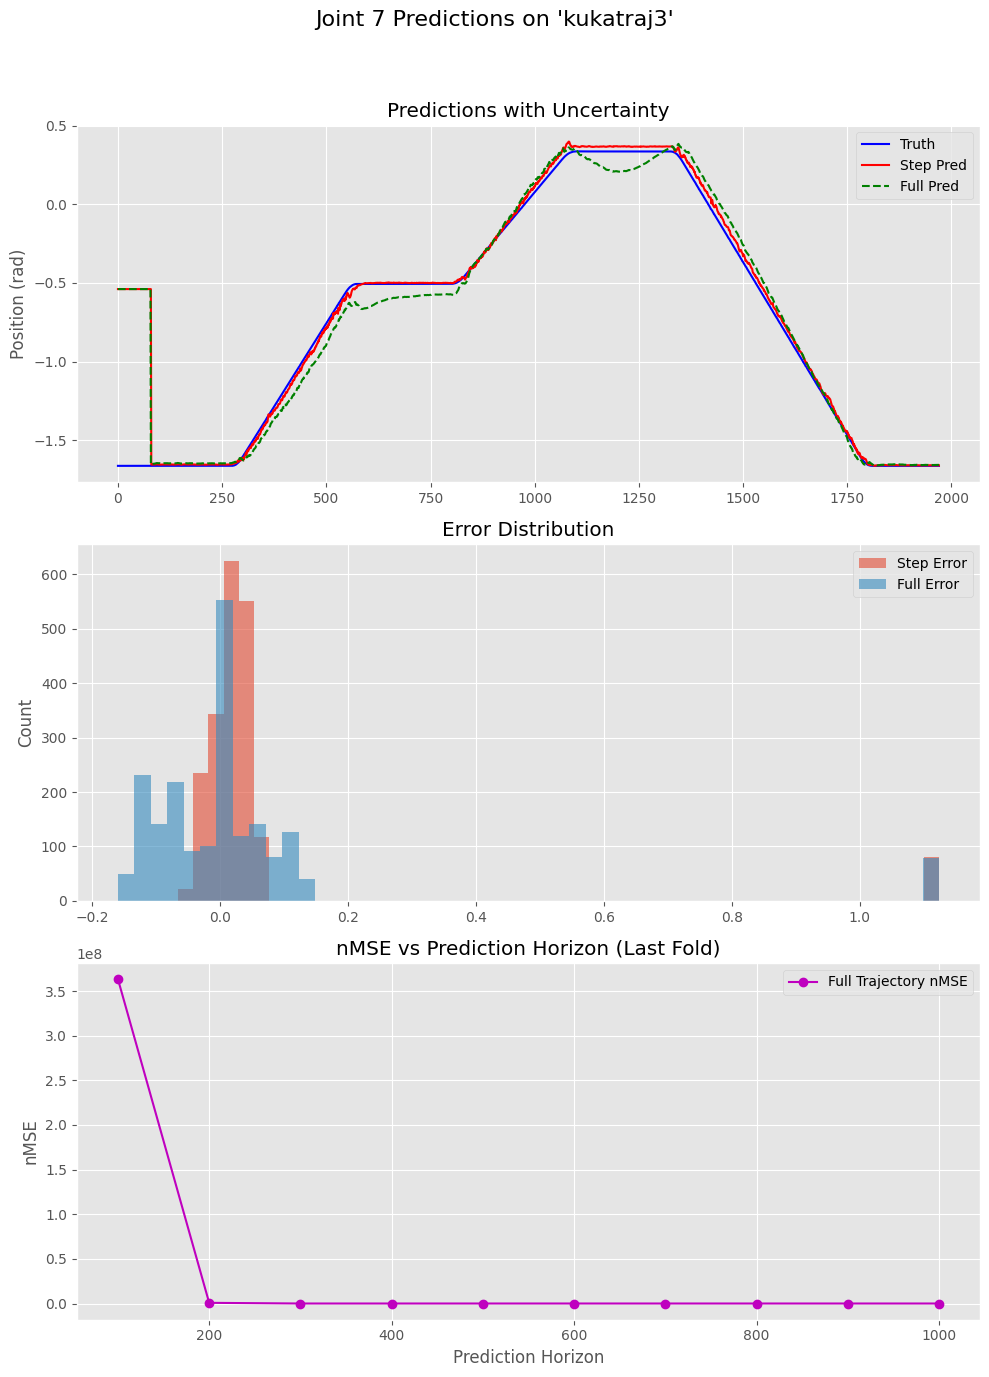

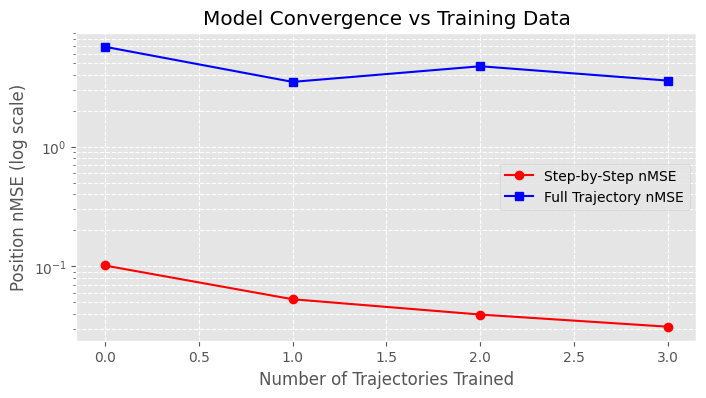

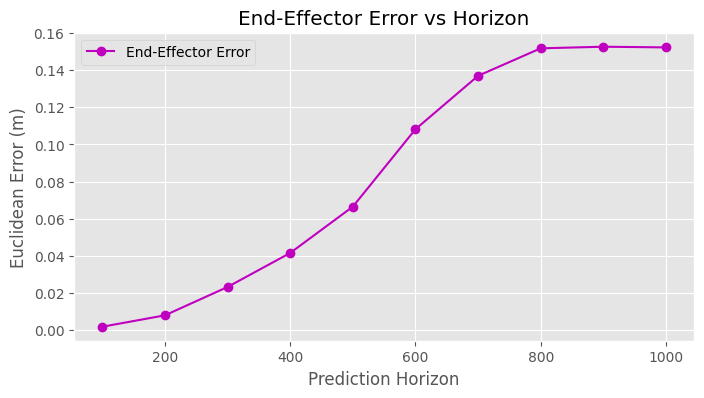

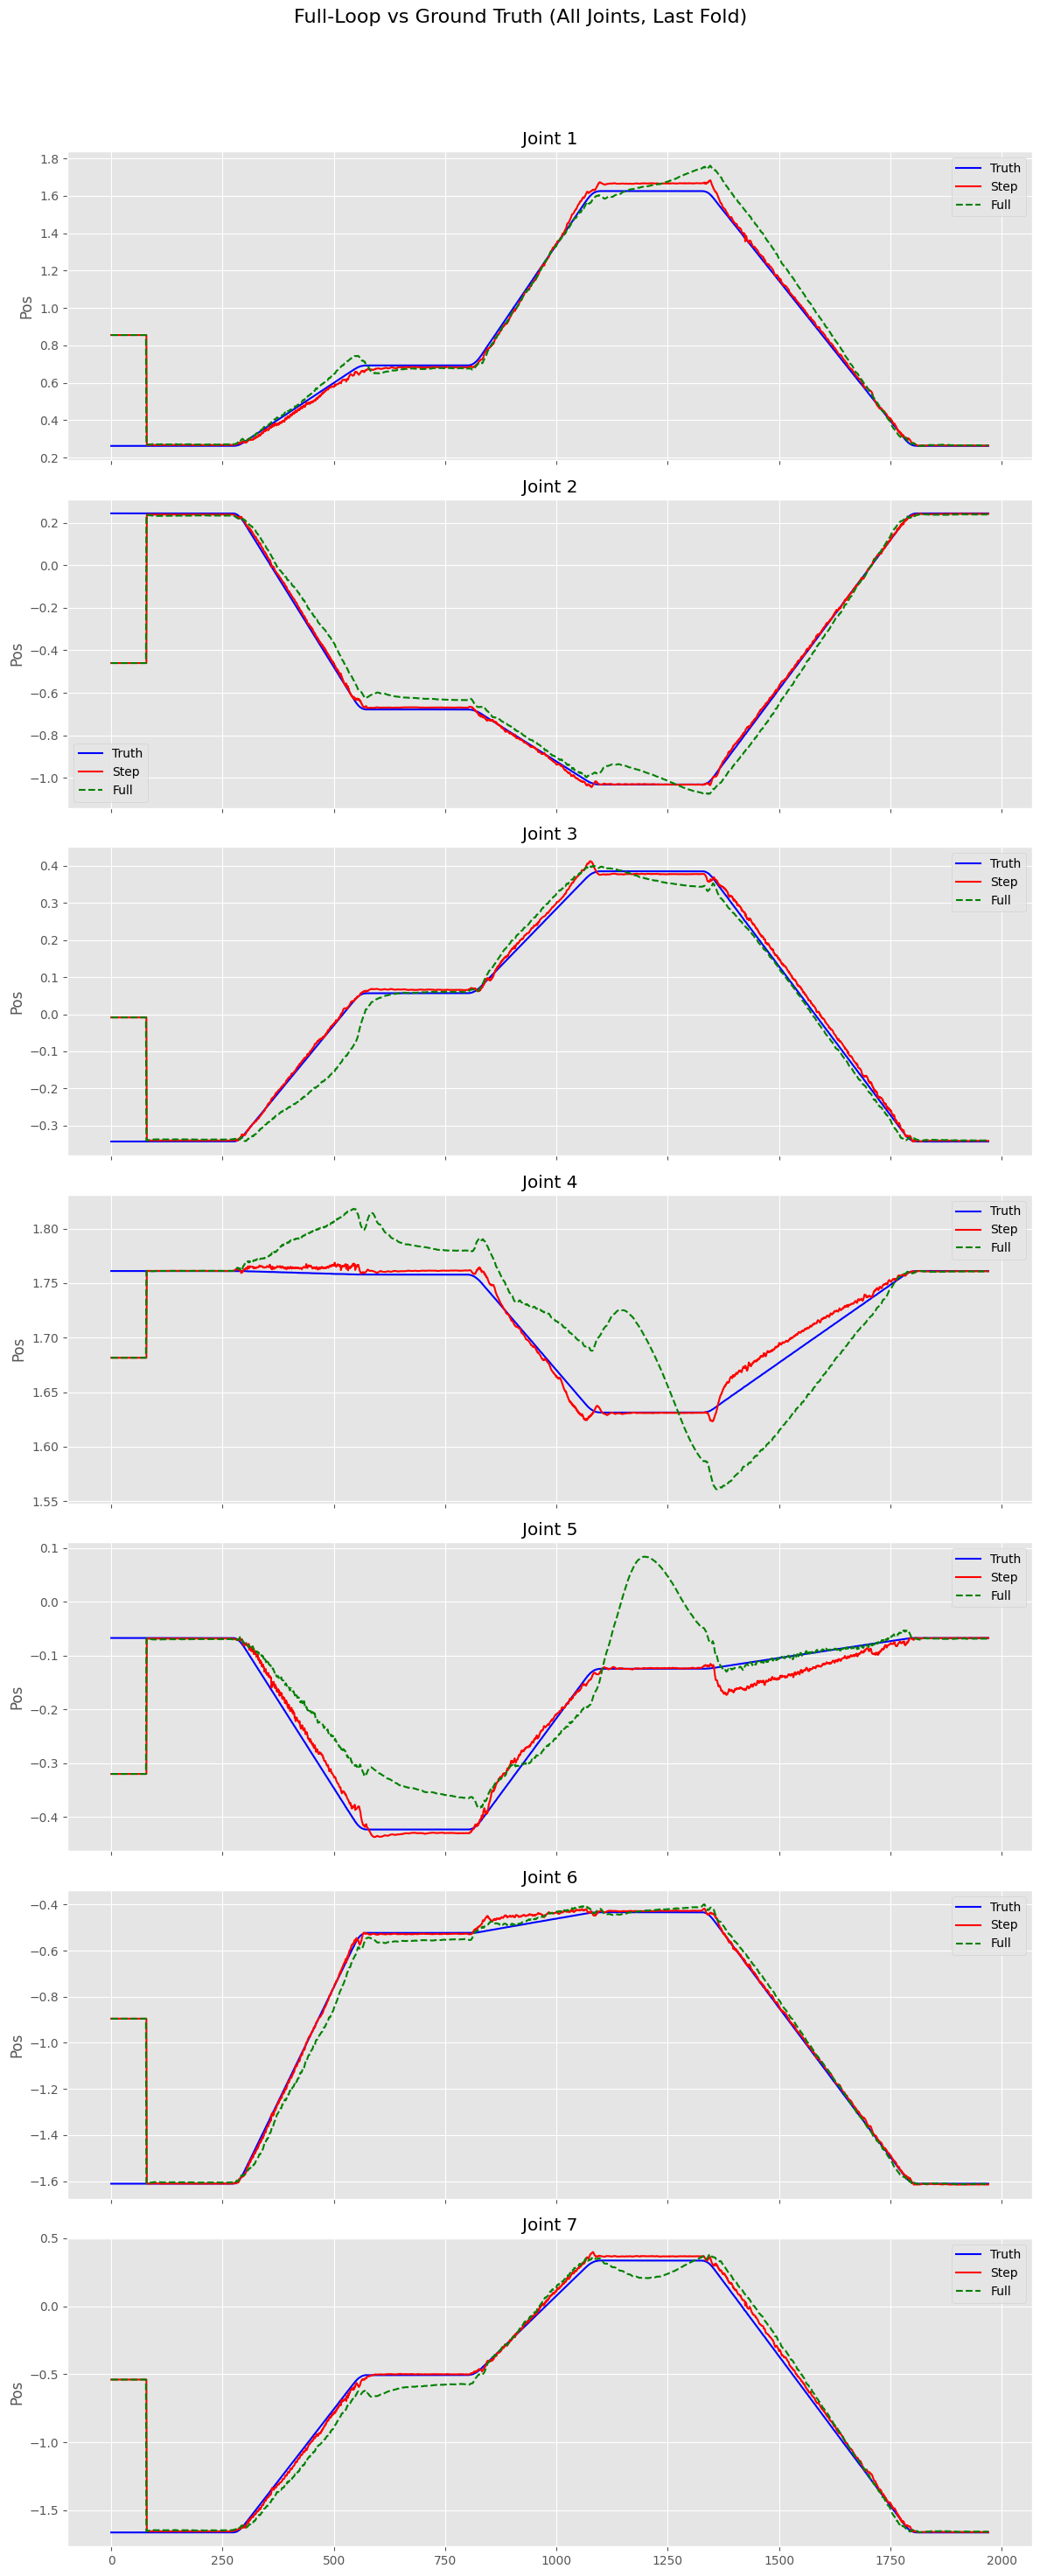

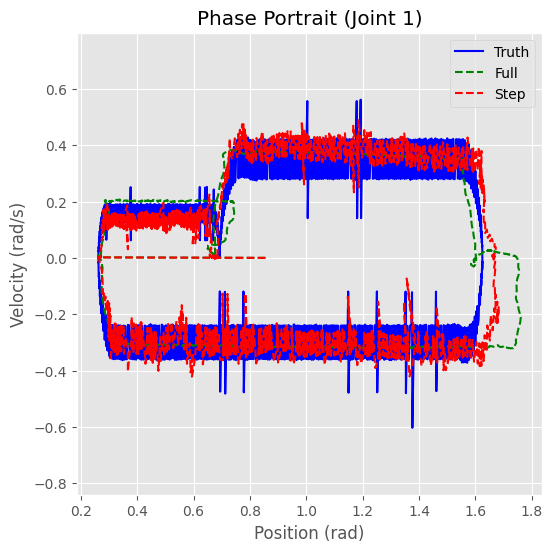

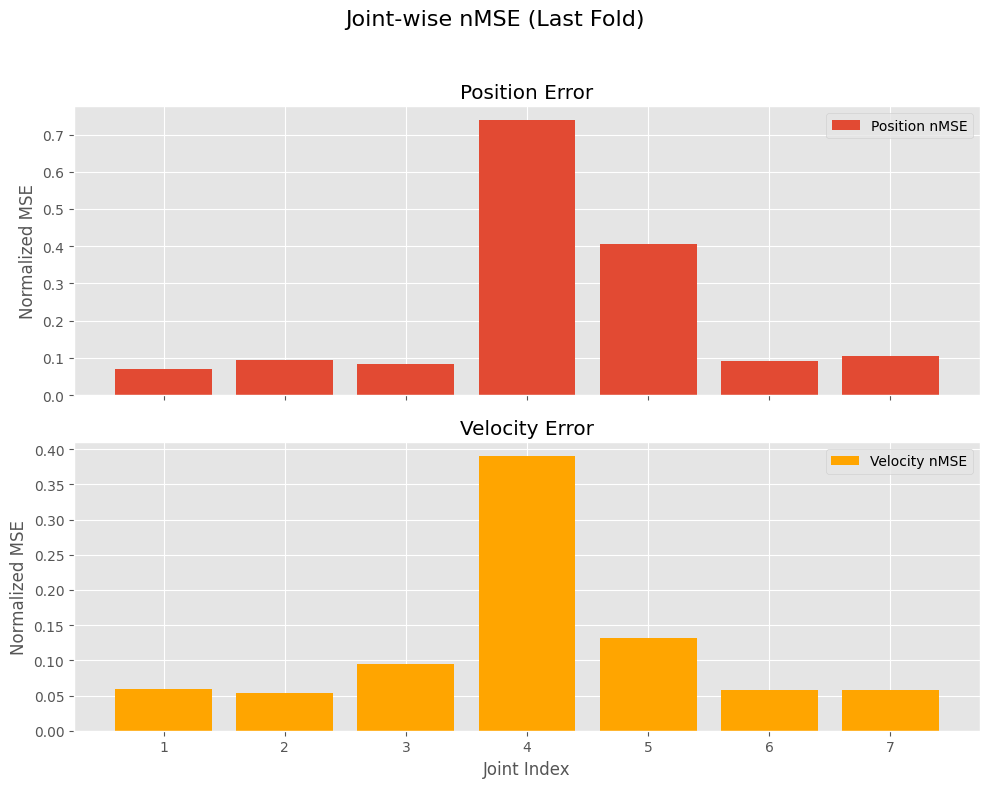

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
#  User-supplied data (assumed defined)
#    last_fold_preds: dict with keys 'true','step','full' as (T × J) arrays
#    results_df: pandas.DataFrame with fold-wise metrics
#    horizons: list of ints
#    test_key: str identifier for this trajectory
# ----------------------------------------

joint_to_plot = 6
y_true = last_fold_preds['true'][:, joint_to_plot]
y_step = last_fold_preds['step'][:, joint_to_plot]
y_full = last_fold_preds['full'][:, joint_to_plot]
#std_full = np.sqrt(last_fold_preds['full_var'][:, joint_to_plot])  # Standard deviation

# 1) Joint-specific overlay + error vs horizon
fig, axs = plt.subplots(3, 1, figsize=(10, 14))
fig.suptitle(f"Joint {joint_to_plot+1} Predictions on '{test_key}'", fontsize=16)

# Plot with uncertainty
axs[0].plot(y_true, 'b-', label='Truth')
axs[0].plot(y_step, 'r-', label='Step Pred')  # No variance for step unless computed
axs[0].plot(y_full, 'g--', label='Full Pred')
#axs[0].fill_between(range(len(y_full)), y_full - std_full, y_full + std_full, color='g', alpha=0.2)
axs[0].set_title('Predictions with Uncertainty')
axs[0].set_ylabel('Position (rad)')
axs[0].legend()
axs[0].grid(True)

# Error histogram
err_step = y_step - y_true
err_full = y_full - y_true
axs[1].hist(err_step, bins=50, alpha=0.6, label='Step Error')
axs[1].hist(err_full, bins=50, alpha=0.6, label='Full Error')
axs[1].set_title('Error Distribution')
axs[1].set_ylabel('Count')
axs[1].legend(); axs[1].grid(True)

# nMSE vs horizon (last fold)
h_vals = [h for h in horizons if f'full_pos_nmse_h{h}' in results_df.columns]
nmse_vals = [results_df.iloc[-1][f'full_pos_nmse_h{h}'] for h in h_vals]
axs[2].plot(h_vals, nmse_vals, 'm-o', label='Full Trajectory nMSE')
axs[2].set_xlabel('Prediction Horizon')
axs[2].set_ylabel('nMSE')
axs[2].set_title('nMSE vs Prediction Horizon (Last Fold)')
axs[2].legend(); axs[2].grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])


# 2) Convergence plot (averaged over folds)
fig2, ax2 = plt.subplots(figsize=(8, 4))
n = len(results_df)
x = np.arange(1, n+1)
ax2.plot(results_df['sbs_pos_nmse'].expanding().mean(),
         'r-o', label='Step-by-Step nMSE')
ax2.plot(results_df['full_pos_nmse'].expanding().mean(),
         'b-s', label='Full Trajectory nMSE')
ax2.set_yscale('log')
ax2.set_xlabel('Number of Trajectories Trained')
ax2.set_ylabel('Position nMSE (log scale)')
ax2.set_title('Model Convergence vs Training Data')
ax2.legend(); ax2.grid(True, which='both', ls='--')


# 3) Operational-space error vs horizon (averaged)
fig3, ax3 = plt.subplots(figsize=(8, 4))
horiz_cols = [f'full_euclid_err_h{h}' for h in horizons
              if f'full_euclid_err_h{h}' in results_df.columns]
mean_op_err = results_df[horiz_cols].mean().values
ax3.plot(horizons[:len(mean_op_err)], mean_op_err,
         'm-o', label='End-Effector Error')
ax3.set_xlabel('Prediction Horizon')
ax3.set_ylabel('Euclidean Error (m)')
ax3.set_title('End-Effector Error vs Horizon')
ax3.legend(); ax3.grid(True)


# 4) All 8 joints, full vs truth (last fold)
fig4, axs4 = plt.subplots(7, 1, figsize=(12, 30), sharex=True)
fig4.suptitle('Full-Loop vs Ground Truth (All Joints, Last Fold)', fontsize=16)
axs4 = axs4.ravel()
n_joints = 7
for j in range(n_joints):
    axs4[j].plot(last_fold_preds['true'][:, j], 'b-')
    axs4[j].plot(last_fold_preds['step'][:, j], 'r-')
    axs4[j].plot(last_fold_preds['full'][:, j], 'g--')
    axs4[j].set_title(f'Joint {j+1}')
    axs4[j].set_ylabel('Pos'); axs4[j].legend(['Truth','Step','Full']); axs4[j].grid(True)
# hide extra subplot if 8<9
if len(axs4) > n_joints:
    axs4[-1].set_visible(False)
plt.tight_layout(rect=[0, 0, 1, 0.95])


# 5) Phase portrait for a sample joint
fig5, ax5 = plt.subplots(figsize=(6, 6))
j0 = 0
pos = last_fold_preds['true'][:, j0]
vel = last_fold_preds['true'][:, j0+7]  # assumes 8 pos + 8 vel
ax5.plot(pos, vel,  'b-', label='Truth')
ax5.plot(last_fold_preds['full'][:, j0],
         last_fold_preds['full'][:, j0+7],
         'g--', label='Full')
ax5.plot(last_fold_preds['step'][:, j0],
         last_fold_preds['step'][:, j0+7],
         'r--', label='Step')
ax5.set_xlabel('Position (rad)')
ax5.set_ylabel('Velocity (rad/s)')
ax5.set_title(f'Phase Portrait (Joint {j0+1})')
ax5.legend(); ax5.grid(True); ax5.axis('equal')

# 6) Joint-wise nMSE bar chart
true_all = last_fold_preds['true']
full_all = last_fold_preds['full']
var_per_joint = true_all.var(axis=0)
var_per_joint[var_per_joint == 0] = 1 # Avoid division by zero
nmse_full = ((full_all - true_all)**2).mean(axis=0) / var_per_joint

# Separate nMSE for position (first 7 values) and velocity (last 7 values)
nmse_pos = nmse_full[:7]
nmse_vel = nmse_full[7:]
joint_indices = np.arange(1, 8)

# Create a figure with two subplots
fig6, (ax_pos, ax_vel) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
fig6.suptitle('Joint-wise nMSE (Last Fold)', fontsize=16)

# Position nMSE plot
ax_pos.bar(joint_indices, nmse_pos, label='Position nMSE')
ax_pos.set_ylabel('Normalized MSE')
ax_pos.set_title('Position Error')
ax_pos.legend(); ax_pos.grid(True)

# Velocity nMSE plot
ax_vel.bar(joint_indices, nmse_vel, color='orange', label='Velocity nMSE')
ax_vel.set_xlabel('Joint Index')
ax_vel.set_ylabel('Normalized MSE')
ax_vel.set_title('Velocity Error')
ax_vel.set_xticks(joint_indices)
ax_vel.legend(); ax_vel.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])